<a href="https://www.kaggle.com/code/pratul007/amazon-review-dataset-ipynb?scriptVersionId=151215939" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1_l2
from sklearn.utils import class_weight
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package wordnet to /root/nltk_data...

[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Load data
data = pd.read_json('/kaggle/input/amazon-reviews/Cell_Phones_and_Accessories_5.json', lines=True)
data.info()

In [ ]:
# Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', text)  # Remove emails
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

data['cleaned_review'] = data['reviewText'].apply(lambda x: clean_text(str(x)))
data['tokenized_review'] = data['cleaned_review'].apply(tokenize_and_remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package wordnet to /root/nltk_data...

[nltk_data]   Package wordnet is already up-to-date!


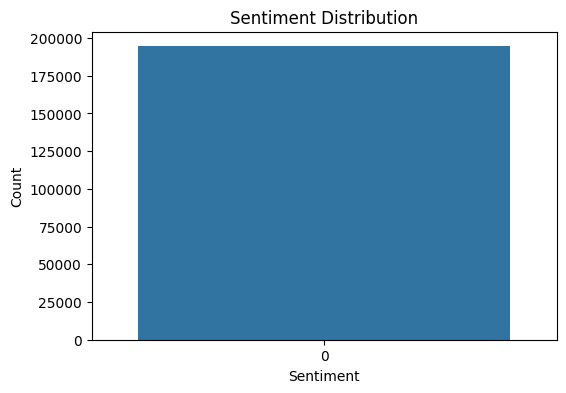

In [ ]:
# Sentiment Distribution
data['sentiment'] = data['overall'].apply(lambda x: 1 if x > 3 else 0)
plt.figure(figsize=(6, 4))
sns.countplot(data['sentiment'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

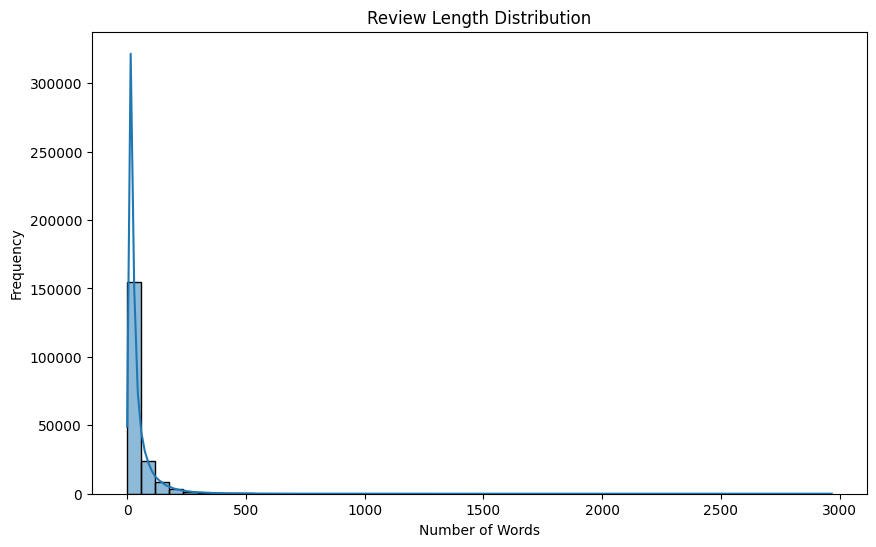

In [ ]:
# Review Length Distribution
data['review_length'] = data['tokenized_review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], bins=50, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

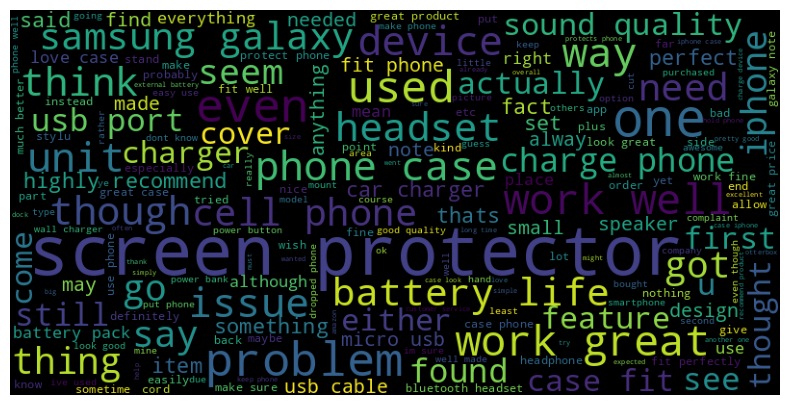

In [ ]:
# Word Frequency Analysis
all_words = ' '.join(data['tokenized_review'].tolist())
wordcloud = WordCloud(width=800, height=400).generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# Feature Engineering with Word Embeddings
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['tokenized_review'])
sequences = tokenizer.texts_to_sequences(data['tokenized_review'])
X = pad_sequences(sequences, maxlen=100)
y = data['sentiment']

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Class Weights Calculation
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Model Architecture Adjustments
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(SpatialDropout1D(0.25))  # Increased dropout
model.add(Bidirectional(LSTM(50, dropout=0.25)))  # Adjusted LSTM units and dropout
model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))  # Adjusted Dense layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Model Training with Class Weights
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights, callbacks=[es, mc])


Epoch 1/15

2431/2431 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.7881

Epoch 1: val_accuracy improved from -inf to 0.78389, saving model to best_model.h5

2431/2431 [==============================] - 68s 27ms/step - loss: 0.4685 - accuracy: 0.7881 - val_loss: 0.4527 - val_accuracy: 0.7839

Epoch 2/15

   6/2431 [..............................] - ETA: 27s - loss: 0.4181 - accuracy: 0.7969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


2431/2431 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8179

Epoch 2: val_accuracy improved from 0.78389 to 0.83686, saving model to best_model.h5

2431/2431 [==============================] - 32s 13ms/step - loss: 0.4076 - accuracy: 0.8179 - val_loss: 0.3703 - val_accuracy: 0.8369

Epoch 3/15

2431/2431 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8296

Epoch 3: val_accuracy did not improve from 0.83686

2431/2431 [==============================] - 31s 13ms/step - loss: 0.3841 - accuracy: 0.8296 - val_loss: 0.3829 - val_accuracy: 0.8279

Epoch 4/15

2431/2431 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.8356

Epoch 4: val_accuracy did not improve from 0.83686

2431/2431 [==============================] - 31s 13ms/step - loss: 0.3688 - accuracy: 0.8356 - val_loss: 0.4274 - val_accuracy: 0.8020

Epoch 5/15

2431/2431 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8427

Epoch 5: val_

In [ ]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print(classification_report(y_test, y_pred))

1216/1216 [==============================] - 6s 4ms/step

              precision    recall  f1-score   support



           0       0.60      0.81      0.69      9099

           1       0.94      0.83      0.88     29789



    accuracy                           0.83     38888

   macro avg       0.77      0.82      0.78     38888

weighted avg       0.86      0.83      0.84     38888




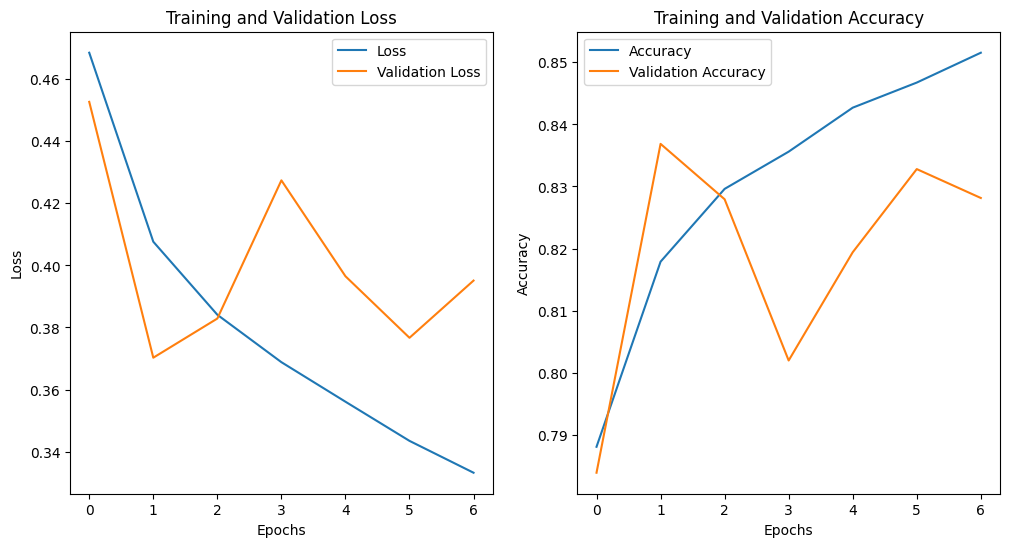

In [ ]:
# Plotting Training History
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the Final Model
model.save('/kaggle/input/best-model')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(
